# Comparing the simulation of a random GBS circuit with bosonicplus and strawberryfield's Fock backend

In [1]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
#import strawberryfields as sf

from bosonicplus.operations.parameters import gen_interferometer_params
from bosonicplus.operations.gbs import build_interferometer
from bosonicplus.base import State
from bosonicplus.fidelity import fidelity_bosonic
from bosonicplus.plotting import plot_wig
from time import time

## Simulate GBS circuit with bosonicplus

In [2]:
num = 3

np.random.seed(91) #Seed for random circuit parameters
ti = time()
params = gen_interferometer_params(num,-8)
print('Building the interferometer')
print('-'*50)
state_coherent = build_interferometer(params, num, out = True)
#circuit = build_interferometer(params, num, out=True)
t1 = time()
print(f'Circuit building time = {t1-ti} s')
n = 5
ns = np.repeat(n, num-1) #Photon pattern

print('\nPerforming photon measurements')
print('-'*50)

T0 = time()

for i, n in enumerate(ns):
    
    t0 = time()
    
    #modes = circuit.get_modes()
    modes = np.arange(state_coherent.num_modes)
    
    #state.post_select_fock_coherent(circuit, modes[-1], n,out=True)
    state_coherent.post_select_fock_coherent(modes[-1], n, inf=1e-5, out=True)
    
    t1 = time()
    print(f'Post selection time {t1-t0} s')

T1 = time()

print(f'Total time for measurements {T1-T0} s')

print(f'\nTotal simulation time {T1-ti} s')
    

Building the interferometer
--------------------------------------------------
Sgate[0.265,-2.555] on mode 0
Sgate[0.370,-1.049] on mode 1
Sgate[0.343,1.415] on mode 2
BSgate[0.994,0.800] on modes 0 and 1
BSgate[0.792,3.093] on modes 1 and 2
BSgate[1.399,-2.663] on modes 0 and 1
Circuit building time = 0.0014667510986328125 s

Performing photon measurements
--------------------------------------------------
Measuring 5 photons in mode 2.
Data shape before measurement, [(1, 6), (1, 6, 6), (1,)].
Probability of measurement = 4.047e-05+0.000e+00j
Data shape after measurement, [(36, 4), (1, 4, 4), (36,)]
Post selection time 0.0018138885498046875 s
Measuring 5 photons in mode 1.
Data shape before measurement, [(36, 4), (1, 4, 4), (36,)].
Probability of measurement = 1.093e-07-2.665e-15j
Data shape after measurement, [(1296, 2), (1, 2, 2), (1296,)]
Post selection time 0.0025789737701416016 s
Total time for measurements 0.004509925842285156 s

Total simulation time 0.006308794021606445 s


## Simulate the circuit in strawberryfields Fock basis

In [3]:
import strawberryfields as sf
from strawberryfields.ops import Sgate, BSgate, MeasureFock, MeasureHomodyne

In [4]:
sqz = params['sqz']
bs = params['bs']

eng = sf.Engine('fock', backend_options={"cutoff_dim": 20})
prog = sf.Program(num)

ns_fock = ns.tolist()

t0 = time()

with prog.context as q:
    for i in range(num):
        Sgate(sqz[i][0], sqz[i][1]) | q[i]
    for i in range(len(bs)):
        BSgate(bs[i][0], bs[i][1]) | (q[bs[i][2][0]], q[bs[i][2][1]])
        
    for i in range(num-1):
        MeasureFock(select = ns_fock[i]) | q[(num-1)-i] #Measure the last mode

result = eng.run(prog)

tf = time()

print(f'Total simulation time {tf-t0}')

Total simulation time 2.3057241439819336


## Comparing the output state from both methods
Increasing the `cutoff_dim` in `backend_options` in `eng` will improve strawberryfield's accuracy.

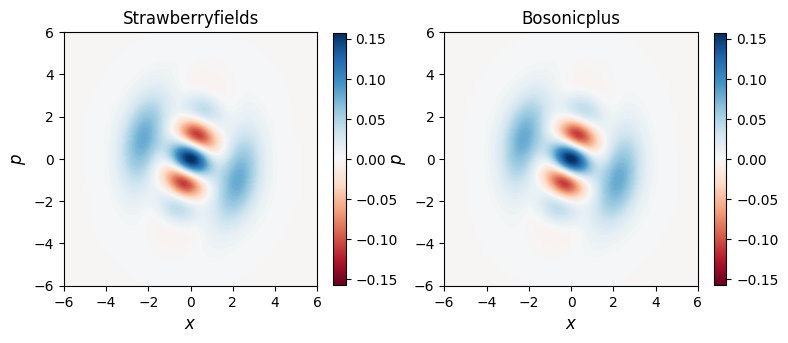

Fidelity to vacuum sf:  0.2213390401360774
Fidelity to vacuum bosonicplus:  (0.2213166069656603-4.5397725088930355e-08j)
Number expectation sf:  (1.6829402500088129, 1.1403083259783338)
Number expectation bosonicplus:  ((1.6830272441729903+4.598405212163925e-08j), (1.5228535941569135+4.7031790018081665e-08j))


In [5]:
state = result.state

x = np.linspace(-6,6,100)
W = state.wigner(0, x,x)

fig, axes = plt.subplots(1,2, figsize = (9,4))
plot_wig(axes[0], W ,x,x)
axes[0].set_title(f'Strawberryfields')
W_coherent = state_coherent.get_wigner(x,x)
plot_wig(axes[1], W_coherent, x, x)
axes[1].set_title(f'Bosonicplus')

plt.show()


print('Fidelity to vacuum sf: ', state.fidelity_vacuum() )
print('Fidelity to vacuum bosonicplus: ', fidelity_bosonic(state_coherent, State()))

print('Number expectation sf: ', state.mean_photon(0))
print('Number expectation bosonicplus: ', state_coherent.get_mean_photons())

## Post selecting on psuedo PNRD measurement outcome with bosonicplus
This method will run into precision issues the higher the number of on/off detectors per click detector `M` for the same reason that the bosonicbackend's Fock approximation runs into precision issues. 

In [6]:
num = 3
M = 8 #Number of on/off detectors per pPNRD
n = 5
ns = np.repeat(n, num-1) #Click outcomes

ti = time()
#params = gen_interferometer_params(num,12)
print('Building the interferometer')
print('-'*50)
state_th = build_interferometer(params, num, out=True)
#circuit = build_interferometer(params, num, out=True)
t1 = time()
print(f'Circuit building time = {t1-ti} s')

print('\nPerforming click measurements')
print('-'*50)

T0 = time()

for i, n in enumerate(ns):
    
    t0 = time()
    modes = np.arange(state_th.num_modes)
    #modes = circuit.get_modes()
    state_th.post_select_ppnrd_thermal(modes[-1], n, M, out=True)
    t1 = time()
    print(f'Post selection time {t1-t0} s')

T1 = time()

print(f'Total time for measurements {T1-T0} s')

print(f'\nTotal simulation time {T1-ti} s')
    

Building the interferometer
--------------------------------------------------
Sgate[0.265,-2.555] on mode 0
Sgate[0.370,-1.049] on mode 1
Sgate[0.343,1.415] on mode 2
BSgate[0.994,0.800] on modes 0 and 1
BSgate[0.792,3.093] on modes 1 and 2
BSgate[1.399,-2.663] on modes 0 and 1
Circuit building time = 0.0009641647338867188 s

Performing click measurements
--------------------------------------------------
Measuring 5 clicks in mode 2.
Data shape before measurement, [(1, 6), (1, 6, 6), (1,)].
Probability of measurement = 1.143e-05
Data shape after measurement, [(6, 4), (6, 4, 4), (6,)]
Post selection time 0.00032711029052734375 s
Measuring 5 clicks in mode 1.
Data shape before measurement, [(6, 4), (6, 4, 4), (6,)].
Probability of measurement = 1.233e-08
Data shape after measurement, [(36, 2), (36, 2, 2), (36,)]
Post selection time 0.00031304359436035156 s
Total time for measurements 0.0007181167602539062 s

Total simulation time 0.0017352104187011719 s


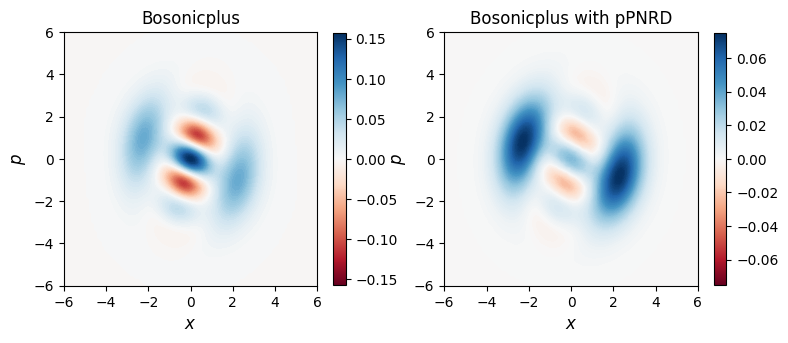

In [7]:
fig, axes = plt.subplots(1,2, figsize = (9,4))
plot_wig(axes[0], W_coherent, x, x)

axes[0].set_title(f'Bosonicplus')

#state_th = get_state(circuit)
W = state_th.get_wigner(x,x)

plot_wig(axes[1], W, x, x)
axes[1].set_title(f'Bosonicplus with pPNRD')

plt.show()

## Test circuit

In [8]:
from thewalrus.symplectic import xxpp_to_xpxp, expand, squeezing, beam_splitter
nmodes =3
n = 6
S1 = xxpp_to_xpxp(expand(squeezing(0.5),[0], nmodes))
S2 = xxpp_to_xpxp(expand(squeezing(1, np.pi),[1], nmodes))
S3 = xxpp_to_xpxp(expand(squeezing(0.5),[2], nmodes))
BS1 = xxpp_to_xpxp(expand(beam_splitter(np.pi/3, 0), [0,1],nmodes))
BS2 = xxpp_to_xpxp(expand(beam_splitter(np.pi/5, 0), [1,2],nmodes))

Stot = BS2@BS1@S3@S2@S1


state = State(nmodes)
state.apply_symplectic(Stot)
state.post_select_fock_coherent(0, n, 1e-4)
state.post_select_fock_coherent(0, n, 1e-4)



eng = sf.Engine('fock', backend_options={"cutoff_dim": 25})
prog = sf.Program(num)

ns_fock = [n,n]

t0 = time()

with prog.context as q:
    
    Sgate(0.5,0) | q[0]
    Sgate(1,np.pi) | q[1]
    Sgate(0.5,0) | q[2]
    
    BSgate(np.pi/3, 0) | (q[0], q[1])
    BSgate(np.pi/5, 0) | (q[1], q[2])
        
    for i in range(num-1):
        MeasureFock(select = ns_fock[i]) | q[i] #Measure the first mode

result = eng.run(prog)


In [9]:
print(result.state.mean_photon(2))
print(result.state.fidelity_vacuum())
print(state.get_mean_photons())
print(fidelity_bosonic(state, State()))


(0.6783735266693751, 1.2103871063143152)
0.6979407608878457
((0.6783800663820703+2.255973186038318e-13j), (0.4821014173473266-4.583000645652646e-13j))
(0.6979389938735644-5.178030232215504e-13j)


In [10]:
state = State(nmodes)
state.apply_symplectic(Stot)
state.post_select_homodyne(0, 0, 0)
state.post_select_homodyne(0, 0, 0)

eng = sf.Engine('gaussian')
prog = sf.Program(nmodes)

t0 = time()

with prog.context as q:
    Sgate(0.5,0) | q[0]
    Sgate(1,np.pi) | q[1]
    Sgate(0.5,0) | q[2]
    
    BSgate(np.pi/3, 0) | (q[0], q[1])
    BSgate(np.pi/5, 0) | (q[1], q[2])
    for i in range(num-1):
        MeasureHomodyne(0, select = 0) | q[i] #Measure the first mode

result = eng.run(prog)


In [11]:
print(result.state.mean_photon(2))
print(result.state.fidelity_vacuum())
print(state.get_mean_photons())
print(fidelity_bosonic(state, State()))

(0.22398928178451882, 0.548320960277727)
0.9038808650986042
(0.22398928620364913, 0.5483209730753389)
0.903880863466904
